# Exercise 6-2 d)

## Markov Chain Monte Carlo

In this notebook you will first implement the analytical solution from exercise 6-2 b) and then you will implement the Metropolis-Hastings algorithm.

Let's start with importing some modules.

In [2]:
import numpy as np
from matplotlib import pyplot as plt

The following function will create a normal distributed dataset with a normal distributed mean:

In [5]:
def random_dataset(param_mean, dimension, datapoints):
    mus = np.random.normal(param_mean, 1, dimension)
    print(mus)
    data = np.array([np.random.normal(mu, 1, datapoints) for mu in mus]).T
    return data

dataset = random_dataset(5, 1, 100)

[3.76070226]


Implement the analytical solution of exercise 6-2 b):

In [6]:
def gauss(x, mu, sigma):
    dim = len(mu)
    assert x.shape[1] == dim
    d = (x-mu)
    scale = 1/np.sqrt((2*np.pi)**dim * np.linalg.det(sigma))
    exponent = -0.5 * np.array([np.transpose(dd) @ np.linalg.inv(sigma) @ dd for dd in d])
    result = scale * np.exp(exponent)
    return result

def analytically(dataset):
    points = dataset.shape[0]
    dim = dataset.shape[1]
    mu = 1/(points+1) * np.sum(dataset, axis=0)
    print(np.sqrt(1/(points+1)))
    return lambda theta: gauss(theta, mu, np.sqrt(1/(points+1)) * np.eye(dim))

0.09950371902099892
CPU times: user 76 µs, sys: 8 µs, total: 84 µs
Wall time: 87 µs
argmax [3.78787879]


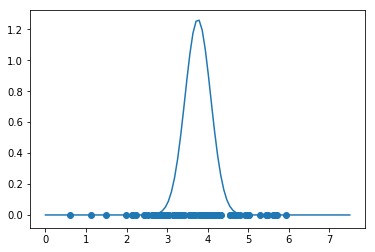

In [9]:
%time f = analytically(dataset)
theta = np.linspace(0, 7.5, 100).reshape((100, 1))
p = np.array([f(np.array([i])) for i in theta])
plt.plot(theta, p)
plt.scatter(dataset, np.zeros(len(dataset)))

print("argmax", theta[np.argmax(p)])

Now, Implement the Metropolis-Hastings Algorithm (see lecture slides):

In [41]:
points = dataset.shape[0]

def gauss_proposal(x):
    return np.random.normal(x, 1)

def gauss_distribution(value, given):
    return gauss(np.array([[value]]), [given], np.eye(dataset.shape[1]))

def gauss_unnormalized(theta): # alternatively you can compute the product of all gaussians (less performant)
    points = dataset.shape[0]
    dim = dataset.shape[1]
    mu = 1/(points+1) * np.sum(dataset, axis=0)
    return gauss(np.array([[theta]]), mu, np.sqrt(1/(points+1)) * np.eye(dim))

def metropolis_hastings_mcmc(dataset, samples, theta_0, sample_proposal, proposal_distribution, unnormalized, bins=100):
    theta = theta_0
    sampled = []
    for _ in range(samples):
        proposed = sample_proposal(theta)
        # since we have a symetric proposal distribution
        # (proposal_distribution(theta, proposed) == proposal_distribution(proposed, theta))
        # we could use unnormalized(proposed) / unnormalized(theta) (=> Metropolis algorithm)
        accept_ratio = min(1, unnormalized(proposed) * proposal_distribution(proposed, theta)
                           / unnormalized(theta) / proposal_distribution(theta, proposed))
        if np.random.random() <= accept_ratio:
            theta = proposed
        sampled.append(theta)
    hist_y, hist_x = np.histogram(sampled, bins)
    hist_y, hist_x = np.asarray(hist_y) / samples / (hist_x[1]-hist_x[0]), np.asarray(hist_x)
    return lambda theta: max(0, hist_y[np.argmin(np.abs(hist_x - theta))-1])

CPU times: user 4.15 s, sys: 3.57 ms, total: 4.15 s
Wall time: 4.81 s
argmax [4.34343434]


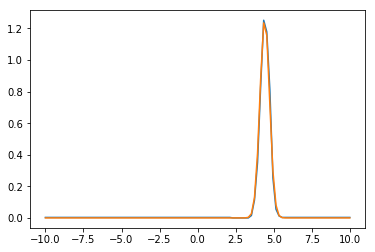

In [42]:
%time mcmc_f = metropolis_hastings_mcmc(dataset, 10000, 0, gauss_proposal, gauss_distribution, gauss_unnormalized, 100)

p_mcmc = np.array([mcmc_f(i) for i in theta])
plt.plot(theta, p_mcmc)
plt.plot(theta, p)

print("argmax", theta[np.argmax(p)])